In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import scipy.io


# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
#  A hook to report the progress of a download. This is mostly intended for users with
#  slow internet connections. Reports every 1% change in download progress.
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
    else:
        sys.stdout.write(".")
        sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, force=False):
#  Download a file if not present
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    return filename

In [3]:
# Download the train and test data
#maybe_download('train.tar.gz')
#maybe_download('test.tar.gz')
#maybe_download('extra.tar.gz')
maybe_download('train_32x32.mat')
maybe_download('test_32x32.mat')
maybe_download('extra_32x32.mat')

'extra_32x32.mat'

In [4]:
train_data = scipy.io.loadmat('train_32x32')['X']
train_labels = scipy.io.loadmat('train_32x32')['y']

test_data = scipy.io.loadmat('test_32x32')['X']
test_labels = scipy.io.loadmat('test_32x32')['y']

# extra_data = scipy.io.loadmat('extra_32x32', variable_names = 'X')['X']
# extra_labels = scipy.io.loadmat('extra_32x32', variable_names = 'y')['y']

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

# print(extra_data.shape, extra_labels.shape)

(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 26032) (26032, 1)


In [5]:
# Split 10% of training data to be validation data

train_data = train_data.transpose((3, 0, 1, 2))
test_data = test_data.transpose((3, 0, 1, 2))

train_data, val_data, train_label, val_label = train_test_split(train_data, train_labels, test_size=0.1)

# Train : Test : Validation = 65931 : 26032 : 7326

print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)
print('Validation data shape: ', val_data.shape)

print('label_train shape: ', train_label.shape)
print('label_test shape: ', test_labels.shape)
print('label_validation shape: ', val_label.shape)


Train data shape:  (65931, 32, 32, 3)
Test data shape:  (26032, 32, 32, 3)
Validation data shape:  (7326, 32, 32, 3)
label_train shape:  (65931, 1)
label_test shape:  (26032, 1)
label_validation shape:  (7326, 1)


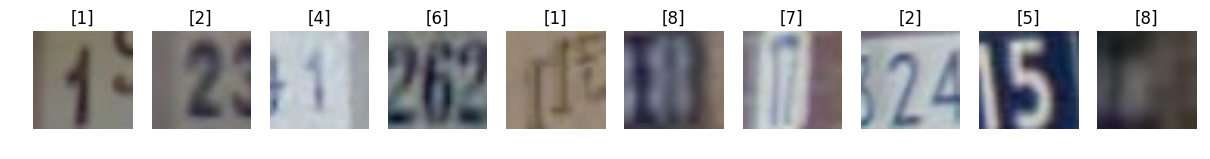

In [13]:
#Display original pictures

plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_label.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_label[j], loc='center')
    ax[i].imshow(train_data[j,:,:,:])


In [6]:
#Feature rescaling

#1. Turn RGB to gray

#Refer to Matlab's rgb2gray algorithm https://www.mathworks.com/help/matlab/ref/rgb2gray.html
#rgb2gray converts RGB values to grayscale values by forming a weighted sum of the R, G, and B components:
#0.2989 * R + 0.5870 * G + 0.1140 * B 

def rgb2gray(image):
    return np.dot(image.astype(float), [[0.2989],[0.5870],[0.1140]])

train_data = rgb2gray(train_data)[:,:,:,0]
test_data = rgb2gray(test_data)[:,:,:,0]
val_data = rgb2gray(val_data)[:,:,:,0]

print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)
print('Validation data shape: ', val_data.shape)

Train data shape:  (65931, 32, 32)
Test data shape:  (26032, 32, 32)
Validation data shape:  (7326, 32, 32)


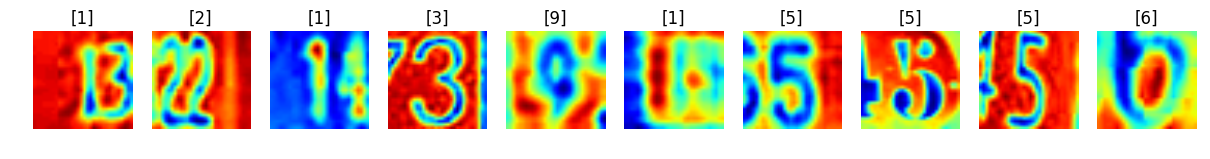

In [19]:
#How it looks after RGB to gray process
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_label.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_label[j], loc='center')
    ax[i].imshow(train_data[j,:,:])

In [7]:
# 0 means and Normalization
def mean_normal(image):
    image_dim = image.shape[0]
    image_norm = np.zeros(image.shape, dtype=float)
    for i in np.arange(image_dim):
        image_norm[i,:,:] = (image[i,:,:] - image[i,:,:].mean())/np.std(image[i,:,:])
    return image_norm

train_data_norm = mean_normal(train_data)
test_data_norm = mean_normal(test_data)
val_data_norm = mean_normal(val_data)

print('train_data_norm shape: ', train_data_norm.shape)
print('train_test_norm shape: ', test_data_norm.shape)
print('train_validation_norm shape: ', val_data_norm.shape)

#del train_data, train_test, train_val

train_data_norm shape:  (65931, 32, 32)
train_test_norm shape:  (26032, 32, 32)
train_validation_norm shape:  (7326, 32, 32)


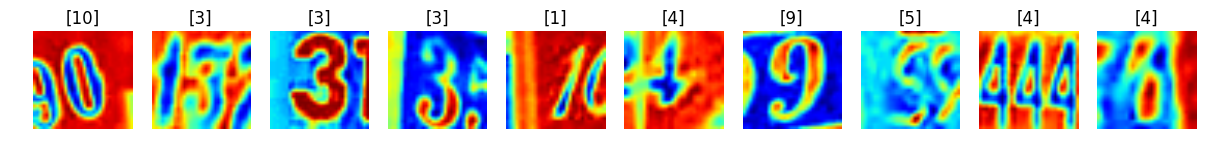

In [21]:
#How it looks after 0 mean and normalization
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_label.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_label[j], loc='center')
    ax[i].imshow(train_data_norm[j,:,:])

In [8]:
pickle_file = 'SVHN_data.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_data': train_data_norm,
        'test_data': test_data_norm,
        'val_data': val_data_norm,
        'train_label': train_label,
        'test_label': test_labels,
        'val_label': val_label,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 813475208


In [11]:
# # Whitening
# def pca_zca_whitening(image):
#     image_white = np.zeros(image.shape, dtype=float)
#     for i in np.arange(image.shape[0]):
#         sigma = np.dot(image, image.T)/image.shape[1]
#         U,S,V = np.linalg.svd(sigma) 
#         epsilon = 0.1 #Whitening constant, avoid division by zero
#         ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)
#         image_white[i,:,:] = np.dot(ZCAMatrix, image)
#     return image